Code for extracting value in images based on geographic coordinates
If the point fall in empty pixel for the right date, code searches for other images with +-6 days around the initial date

In [ ]:
#import libraries
import os, sys, math, time,pyproj
from fpdf import FPDF
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from numpy import *
import numpy as np
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
from itertools import islice
from multiprocessing import Pool, Process
import multiprocessing
import ntpath
print ("imported")

In [ ]:
# Permanently changes the pandas settings to see full dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
#define paths
#define path for images
imgIn=r'F:\Backup Doctorado complet - mars 2023\DOCTORADO\TEMP\cut_concentrations2022'

#define path for table containing coordinates and dates
tableIn=pd.read_excel(r"F:\Backup Doctorado complet - mars 2023\DOCTORADO\TEMP\table_coordinatesAndSPMconcentration.xlsx")

#define path for outputs
imgOut=r'C:/essai/extract/'

#define path for temp folder
tempFolder=r'C:/essai/extract/temp/'

#define column containing field values and define units for plotting
columnOfInterest='SPM in mg/L'
unit=' mg/L'

For tableIn: empty cells must be filled with 'nan' \
structure for input table:
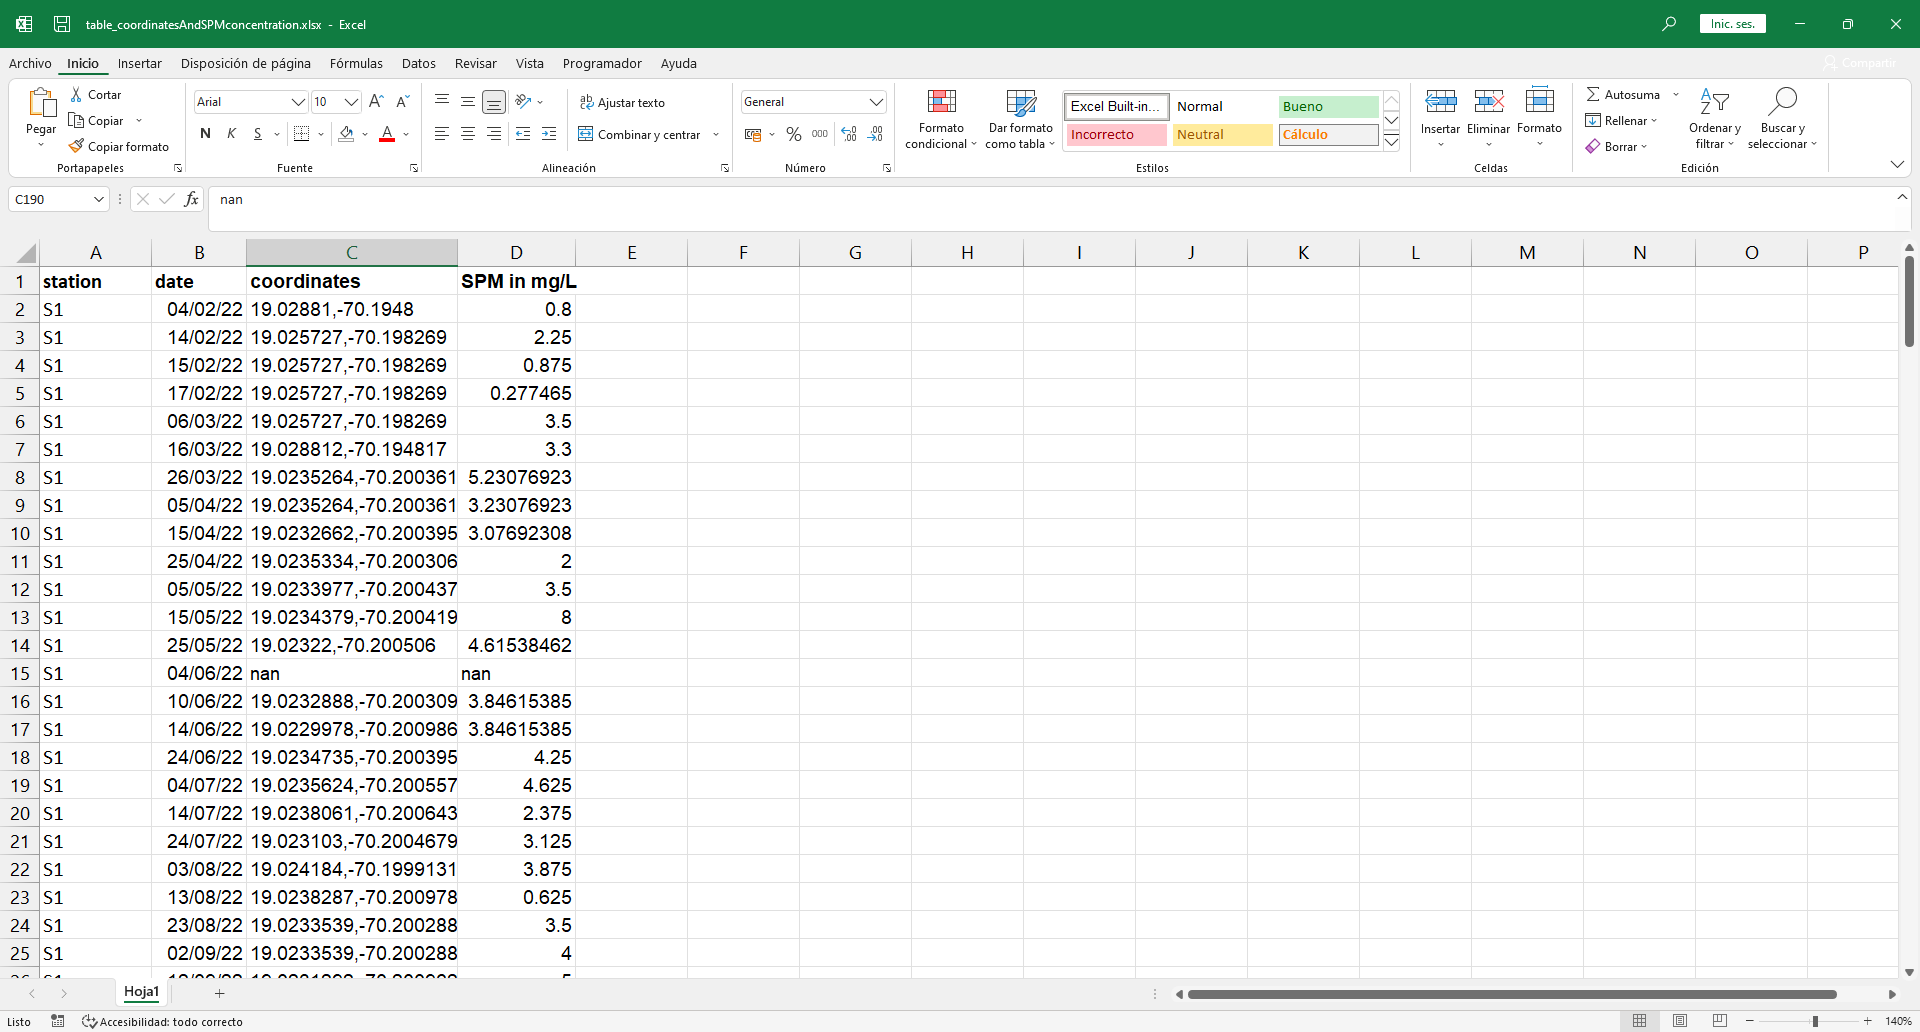

In [ ]:
tableIn

In [ ]:
#define function for plotting image, point and extract value
def extraction (img,coordUTM,fieldValue): #entry data: image containing value to extract and coordinates in UTM of one point
    dataset = gdal.Open(img)
    band = dataset.GetRasterBand(1)
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    transform = dataset.GetGeoTransform()#gets coordinates of first pixel and spatial resolution
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]
    print ("nb of cols and rows, coord and spatial resolution of first pixel:",cols, rows,transform)
    data = band.ReadAsArray(0, 0, cols, rows)
    col = int((coordUTM[0] - xOrigin) / pixelWidth)#get position of point extraction in image coordinates
    row = int((yOrigin - coordUTM[1] ) / pixelHeight)#same
    
    #plot image and add point on plot
    plt.imshow(data,cmap='jet')
    coordPointX=round((coordUTM[0]-transform[0])/transform[1])#dont know why but Easting and Northing stored in coordUTM are inverted
    coordPointY=round((transform[3]-coordUTM[1])/transform[1])#same here
    print (coordPointX,coordPointY)
    imgDateB=datetime.strptime(ntpath.basename(img).split("_")[1][:8], '%Y%m%d').date()
    title='image_'+imgDateB.strftime("%m%d%Y")+' --- point_'+ tableIn.iloc[line]['station']+'_'+ tableIn.iloc[line]['date'].strftime("%m%d%Y")
    plt.plot(coordPointX,coordPointY,marker=".", markersize=5,color='red', alpha=0.5)
    plt.suptitle(title)
    plt.title(str(round(coordUTM[0]))+'m E. / '+str(round(coordUTM[1]))+'m N., img value='+str(data[row][col])+unit+' , field value='+str(round(fieldValue,2))+ unit, fontsize=8)
    
    #plt.show()
    plt.savefig(tempFolder+title+'.jpg', dpi=300)
    plt.close()
    
    return row, col,data[row][col],tempFolder+title+'.jpg' #returns point position in image coordinates and value

In [ ]:
#Create a list of images to process
listImg=[]
for file in os.listdir(imgIn):
    if file.endswith("SPM.tif"):#filter files
        listImg.append(os.path.join(imgIn, file))
        #sort the list aphabetically (important step!) 
    listImg.sort()
listImg 

In [ ]:
driver = gdal.GetDriverByName('GTiff')
listQuickLooks=[]#list for storing images into a pdf

for line in range(tableIn.shape[0]): #loop on every sample (lines in table)
    print ('line #',line)
    print (tableIn.iloc[line]['station'],tableIn.iloc[line]['date']) #print station number and date for the sample
    fieldValue=tableIn.iloc[line][columnOfInterest]
    if pd.isna(tableIn.iloc[line]['coordinates'])is True:#check if this sample contains coordinates or is empty (nan) 
        print("empty")
    else:
        lat, lon = [tableIn.iloc[line]['coordinates'].split(",")[i] for i in range(2)]#read coordinates in Lat/Lon and store it
        transformer=pyproj.Transformer.from_crs("epsg:4326","epsg:32619")#prepare function for CRS transformation
        coordUTM=transformer.transform(lat,lon)#apply function to convert Lat/Lon coordinates to UTM
        print ("point lat/lon and point UTM coord.:",lat, lon,coordUTM)
        
        for img in listImg:#loop on every image
            indexImg = listImg.index(img)#get index number of image in the list
            print ('reference img:',img)
            imgDate=datetime.strptime(ntpath.basename(img).split("_")[1][:8], '%Y%m%d').date()#convert image date (str contained in the name) to date object
            if imgDate==tableIn.iloc[line]['date'].date():#check if image and point date are the same
                print ('match!')
                returnExtraction=extraction (img, coordUTM,fieldValue)#extract value of point for the image
                if pd.isna(returnExtraction[2])is False:#check if value is not nan
                    print ('perfect match!')
                    tableIn.loc[line,'output']=returnExtraction[2]#save value in a new column in the dataframe
                    tableIn.loc[line,'dateImgUsed']=imgDate#save date in a new column
                    tableIn.loc[line,'sameDate']='True'#flag that exact image has been used
                    listQuickLooks.append(returnExtraction[3])
                    print ("returnExtraction")
                    print(returnExtraction)
                    
                else:
                    for deltaIndex in range (1,2):#loop through 3 days (+-2 step in index) around initial date
                        for sign in [-1,1]:#loop through two factors, 1 and -1 (to get +3 and -3 days)
                            print ('index:',indexImg+deltaDay*sign)
                            if (indexImg+deltaDay*sign)<0 or (indexImg+deltaDay*sign>(len(listImg)-1)):
                                print("index out of bounds")
                                break
                            else:
                                img2dTry=listImg[indexImg+deltaDay*sign]#get a new image (by its index) +-6 days around the initial image
                                print (img2dTry)
                                imgDate2d=datetime.strptime(ntpath.basename(img2dTry).split("_")[1][:8], '%Y%m%d').date()#convert new image date to date object
                                returnExtraction2d=extraction (img2dTry, coordUTM,fieldValue)#extract value of point on new image
                                if pd.isna(returnExtraction2d[2])is False:#check if new image value is not nan
                                    tableIn.loc[line,'output']=returnExtraction2d[2]#save new image value
                                    tableIn.loc[line,'dateImgUsed']=imgDate2d#save new image date
                                    tableIn.loc[line,'sameDate']='False'#flag that new image has been used
                                    listQuickLooks.append(returnExtraction2d[3])#save quicklook path for the pdf
                                    print ("returnExtraction2d")
                                    print(returnExtraction2d)
                                    break#get out of loop through two factors
                                else:#keep searching for image with valid value +-6 days around initial image
                                    print('No match, trying with another image') 
                        if pd.isna(returnExtraction2d[2])is False:#as we got out of loop through two factors, now get out of loop through 6 days
                            break#as we got out of loop through two factors, now get out of loop through 6 days       

In [ ]:
#export output
print (tableIn)
tableIn.to_excel(imgOut+"output.xlsx")
#print (listQuickLooks)

pdf = FPDF()
#pdf.set_auto_page_break(0)
# imagelist is the list with all image filenames
for image in sorted(listQuickLooks):
    pdf.add_page()
    pdf.image(image, w=192, h=144)
pdf.output(imgOut+'Extraction.pdf', 'F')
print("Extraction.pdf created")